In [24]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.models as models

from dataset.CombinedDataLoader import CDL

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [26]:
root = './dataset/data'

In [27]:
def get_net(out_dims = 20):
    resnet = models.resnet34(pretrained=True)
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, out_dims)
    return resnet

In [28]:
batch_size = 32

In [29]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [30]:
ds_train = CDL(root, train=True, transform=trans, num_classes=20, images=['cropped', "rotated", "sheared", "skewed"])
ds_test = CDL(root, train=False, transform=trans, num_classes=20, images=['cropped'])

In [31]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [50]:
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, epochs=10, device='cpu', checkpoint_epochs=10):
    print(f'Training for {epochs} epochs on {device}')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        net.train()
        train_loss = torch.tensor(0., device=device)
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if valid_dataloader is not None:
            net.eval()
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')

        train_losses.append((train_loss / len(train_dataloader.dataset)).cpu())
        train_accs.append((train_accuracy / len(train_dataloader.dataset)).cpu())
        valid_losses.append((valid_loss / len(valid_dataloader.dataset)).cpu())
        valid_accs.append((valid_accuracy / len(valid_dataloader.dataset)).cpu())
    return net, train_losses, train_accs, valid_losses, valid_accs

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = get_net(20).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)

epochs = 50

net, train_losses, train_accs, valid_losses, valid_accs = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

Training for 50 epochs on cuda
Epoch 1/50
Training loss: 2.55
Training accuracy: 28.04
Valid loss: 2.09
Valid accuracy: 54.17
Epoch 2/50
Training loss: 1.37
Training accuracy: 83.58
Valid loss: 1.23
Valid accuracy: 83.69
Epoch 3/50
Training loss: 0.74
Training accuracy: 96.00
Valid loss: 0.83
Valid accuracy: 86.99
Epoch 4/50
Training loss: 0.43
Training accuracy: 98.38
Valid loss: 0.64
Valid accuracy: 88.54
Epoch 5/50
Training loss: 0.27
Training accuracy: 99.33
Valid loss: 0.54
Valid accuracy: 88.93
Epoch 6/50
Training loss: 0.18
Training accuracy: 99.75
Valid loss: 0.47
Valid accuracy: 90.49
Epoch 7/50
Training loss: 0.13
Training accuracy: 99.92
Valid loss: 0.44
Valid accuracy: 89.90
Epoch 8/50
Training loss: 0.09
Training accuracy: 100.00
Valid loss: 0.40
Valid accuracy: 89.71
Epoch 9/50
Training loss: 0.07
Training accuracy: 100.00
Valid loss: 0.40
Valid accuracy: 89.13
Epoch 10/50
Training loss: 0.06
Training accuracy: 100.00
Valid loss: 0.37
Valid accuracy: 89.90
Epoch 11/50
Tra

In [52]:
print(f'Top train accuracy:  {float(max(train_accs)):.4f}')
print(f'Top valid accuracy:  {float(max(valid_accs)):.4f}')

Top train accuracy:  1.0000
Top valid accuracy:  0.9049


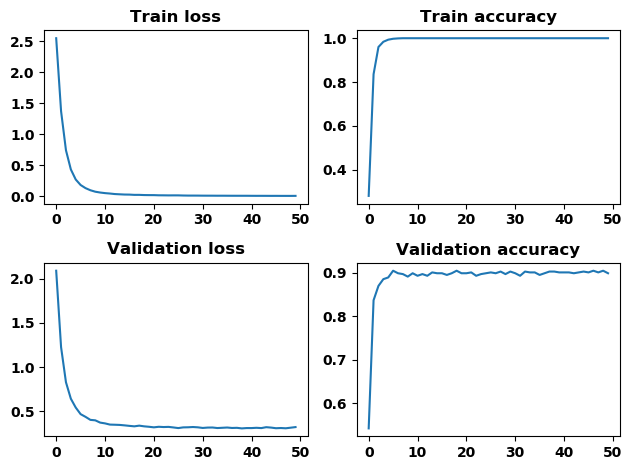

In [55]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title('Train loss')
axs[0, 1].plot(train_accs)
axs[0, 1].set_title('Train accuracy')
axs[1, 0].plot(valid_losses)
axs[1, 0].set_title('Validation loss')
axs[1, 1].plot(valid_accs)
axs[1, 1].set_title('Validation accuracy')
plt.tight_layout()